For the homework, we re-use a great dataset to practice your skills in Keras. We are going to compare classification and regression approaches. As you remember from the previous homework, our wine dataset contains 10 rating levels. Hence, we can also solve this problem as classification task (instead of a regression task). You can find the relevant files under the `wine` subdirectory in the session's folder, but the code below also reloads them for you. This dataset has been used in the following publication:

> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 'Modeling wine preferences by data mining from physicochemical properties.' *Decision Support Systems* 47(4):547-553.

You can find two datasets (encoded as csv-files): one for red wines, and one for white wines. You can load them using `pandas`.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/my_ml_2023/session-7

In [ ]:
import utils
import numpy as np
import torch
from torch import nn


# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)



## Preprocessing (recap)
The longer version of this part can be found in the previous homework. Load the dataset for the white wines (it's also included in the session's folder):

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

--2024-12-10 12:20:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘winequality-white.csv’

winequality-white.c     [   <=>              ] 258.23K   401KB/s    in 0.6s    

2024-12-10 12:21:01 (401 KB/s) - ‘winequality-white.csv’ saved [264426]



In [ ]:
import pandas as pd
white = pd.read_csv('winequality-white.csv', sep=';')
white.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1431,6.1,0.22,0.49,1.5,0.051,18.0,87.0,0.99280,3.30,0.46,9.6,5
445,7.1,0.32,0.32,11.0,0.038,16.0,66.0,0.99370,3.24,0.40,11.5,3
2816,7.2,0.17,0.41,1.6,0.052,24.0,126.0,0.99228,3.19,0.49,10.8,5
4049,6.8,0.16,0.36,1.3,0.034,32.0,98.0,0.99058,3.02,0.58,11.3,6
4779,6.0,0.59,0.00,0.8,0.037,30.0,95.0,0.99032,3.10,0.40,10.9,4
142,7.9,0.21,0.40,1.2,0.039,38.0,107.0,0.99200,3.21,0.54,10.8,6
2703,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5
3252,7.1,0.26,0.37,5.5,0.025,31.0,105.0,0.99082,3.06,0.33,12.6,8
4282,5.7,0.26,0.24,17.8,0.059,23.0,124.0,0.99773,3.30,0.50,10.1,5
46,6.2,0.45,0.26,4.4,0.063,63.0,206.0,0.99400,3.27,0.52,9.8,4


This dataset records, for a large number of (Portugese) wines, a number of objective "physiochemical" properties, such as various kinds of acidity or the level of chlorides. In the very last column ("quality"), it contains a subjective rating for that wine, as an integer  score, ranging from 1 ("very bad") to 10 ("excellent"). This score is a median rating given by at least 3 evaluations made by wine experts.

We'll extract the "quality" column as our $y$ (target value) and features as $X$:

In [ ]:
y_label = white['quality'].values
white = white.drop(['quality'], axis=1)
X = white.values

Note that not all ratings are in fact present in the data -- apparently there were no really bad wines! We ignore this below, for teaching purposes, but normally you'd have to remove the empty classes of course.

In [ ]:
np.unique(y_label)

array([3, 4, 5, 6, 7, 8, 9])

**Task 1.** Divide the available data into a train set (60 %), dev set (20 %) and test set (20 %) using the train_test_split function from Scikit-learn (2 times). It's important to **stratify** these splits in terms of ratings, in order to make sure that we have a similar distribution of ratings in train and test.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_dev_test, y_train, y_dev_test = train_test_split(X, y_label, test_size=0.4,
                                                    random_state=1234, stratify=y_label)

x_dev, x_test, y_dev, y_test = train_test_split(x_dev_test, y_dev_test, test_size=0.5,
                                                    random_state=1234, stratify=y_dev_test)

Note that the stratify argument is crucial. Verify the shapes:

In [ ]:
print(x_train.shape)
print(x_dev.shape)
print(x_test.shape)
print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

(2938, 11)
(980, 11)
(980, 11)
(2938,)
(980,)
(980,)


**Task 2** There's one final bit we need to take care of and that is the normalization of our data: if you inspect the feature values in the dataframe above, you'll notice that the features cover very different ranges. To account for that it's best to normalize our data. Again: use `sklearn` to do it!

In [ ]:
from sklearn.preprocessing import StandardScaler

# conventional standardization: remove mean and divide by std
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_dev = scaler.transform(x_dev)
x_test = scaler.transform(x_test)
print(x_train.shape)
print(x_test.shape)

y_scaler = StandardScaler()

# we add a new dimension to y's (it had just one) to fulfil requirements of StandardScaler (2 dimensions)

y_train_sc = np.expand_dims(y_train, axis=1)
y_dev_sc = np.expand_dims(y_dev, axis=1)

y_train_sc = y_scaler.fit_transform(y_train_sc)
y_dev_sc = y_scaler.transform(y_dev_sc)


(2938, 11)
(980, 11)


# Regression

In [ ]:
def np2set_reg(x, y, shuffle):
  x = torch.tensor(x, dtype=torch.float)
  y =  torch.tensor(y, dtype=torch.float)

  dataset = torch.utils.data.TensorDataset(x, y)
  iterator = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=shuffle)
  return iterator



r_train_iter =  np2set_reg(x_train, y_train_sc, shuffle=True)
r_dev_iter =  np2set_reg(x_dev, y_dev_sc, shuffle=False)
r_test_iter = np2set_reg(x_test, y_test, shuffle=False)

**Task 3.** Base yourself on the code from the notebook for the previous homework and train a linear regression that aims to predict a wine appreciation using all columns. Make sure that your results are **reproducible** by correctly 'seeding'. Use the SGD-optimizer with a learning rate of "0.01" and train for 200 epochs with early stopping (with a "patience" of 5). Thus, early stopping should halt the training process if the validation loss does not improve for 5 (consecutive) epochs. Use MAE, MSE and accuracy to evaluate the results on the test set.

In [ ]:
class RegModel1(nn.Module):
  def __init__(self, in_features, out_features):
    super(RegModel1, self).__init__()
    self.layer = nn.Linear(in_features=11, out_features=1)


  def forward(self, x):
    return self.layer(x)

reg_model = RegModel1(in_features=11, out_features=1)
reg_model = reg_model.cuda()

history = utils.train(model=reg_model,
              loss=nn.MSELoss(),
              val_metrics={"mse": nn.MSELoss()},
              optimizer=torch.optim.SGD(reg_model.parameters(), lr=0.01),
              train_ds=r_train_iter,
              dev_ds=r_dev_iter,
              num_epochs=200,
              early_stopper=utils.EarlyStopper(metric_name="mse", patience=5))


epoch 1 train loss: 0.8671 val_mse: 0.8035
tensor(0.8035) None
epoch 2 train loss: 0.7675 val_mse: 0.7610
tensor(0.7610) tensor(0.8035)
epoch 3 train loss: 0.7446 val_mse: 0.7443
tensor(0.7443) tensor(0.7610)
epoch 4 train loss: 0.7360 val_mse: 0.7400
tensor(0.7400) tensor(0.7443)
epoch 5 train loss: 0.7312 val_mse: 0.7335
tensor(0.7335) tensor(0.7400)
epoch 6 train loss: 0.7288 val_mse: 0.7327
tensor(0.7327) tensor(0.7335)
epoch 7 train loss: 0.7277 val_mse: 0.7325
tensor(0.7325) tensor(0.7327)
epoch 8 train loss: 0.7268 val_mse: 0.7295
tensor(0.7295) tensor(0.7325)
epoch 9 train loss: 0.7258 val_mse: 0.7318
tensor(0.7318) tensor(0.7295)
epoch 10 train loss: 0.7253 val_mse: 0.7292
tensor(0.7292) tensor(0.7295)
epoch 11 train loss: 0.7252 val_mse: 0.7270
tensor(0.7270) tensor(0.7292)
epoch 12 train loss: 0.7249 val_mse: 0.7282
tensor(0.7282) tensor(0.7270)
epoch 13 train loss: 0.7243 val_mse: 0.7264
tensor(0.7264) tensor(0.7270)
epoch 14 train loss: 0.7240 val_mse: 0.7290
tensor(0.7290

/content/utils.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


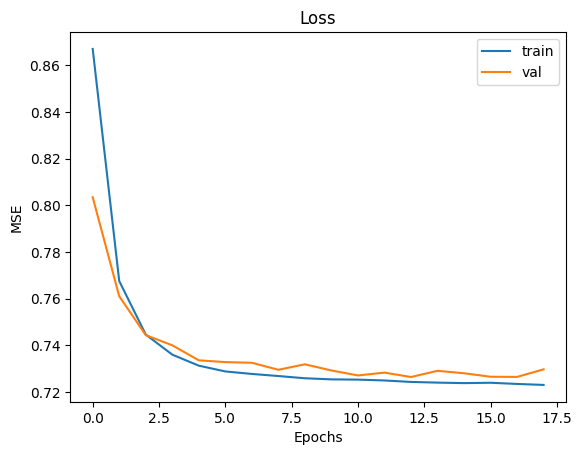

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(history["train_loss"], label='train')
plt.plot(history["val_mse"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE');
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score



def accuracy_from_floats(y_true, y_pred):
  y_pred = np.around(y_pred).astype(int)
  return accuracy_score(y_true=y_true, y_pred=y_pred)

reg_predictions = utils.test(reg_model, r_test_iter)
reg_predictions = y_scaler.inverse_transform(reg_predictions)


print("Accuracy: ",  accuracy_from_floats(y_true=y_test, y_pred=reg_predictions),
      ", MSE: ",mse(y_true=y_test, y_pred=reg_predictions),
      ", MAE", mae(y_true=y_test, y_pred=reg_predictions))

Accuracy:  0.5275510204081633 , MSE:  0.5734203207325338 , MAE 0.5884605476076957


**Task 4.** Add an additional, "hidden" dense layer with the ReLU activation and 30 input/output neurons. Is the result better?

In [ ]:
class RegModel2(nn.Module):
  def __init__(self):
    super(RegModel2, self).__init__()
    self.layer = nn.Sequential(nn.Linear(in_features=11, out_features=30),
                                nn.ReLU(),
                                nn.Linear(in_features=30, out_features=1))


  def forward(self, x):
    return self.layer(x)

reg_model = RegModel2()
reg_model = reg_model.cuda()

history = utils.train(model=reg_model,
              loss=nn.MSELoss(),
              val_metrics={"mse": nn.MSELoss()},
              optimizer=torch.optim.SGD(reg_model.parameters(), lr=0.01),
              train_ds=r_train_iter,
              dev_ds=r_dev_iter,
              num_epochs=200,
              early_stopper=utils.EarlyStopper(metric_name="mse", patience=5))


epoch 1 train loss: 0.9171 val_mse: 0.8401
tensor(0.8401) None
epoch 2 train loss: 0.8237 val_mse: 0.7773
tensor(0.7773) tensor(0.8401)
epoch 3 train loss: 0.7720 val_mse: 0.7394
tensor(0.7394) tensor(0.7773)
epoch 4 train loss: 0.7400 val_mse: 0.7203
tensor(0.7203) tensor(0.7394)
epoch 5 train loss: 0.7190 val_mse: 0.7129
tensor(0.7129) tensor(0.7203)
epoch 6 train loss: 0.7067 val_mse: 0.7038
tensor(0.7038) tensor(0.7129)
epoch 7 train loss: 0.6966 val_mse: 0.6968
tensor(0.6968) tensor(0.7038)
epoch 8 train loss: 0.6895 val_mse: 0.6942
tensor(0.6942) tensor(0.6968)
epoch 9 train loss: 0.6847 val_mse: 0.6887
tensor(0.6887) tensor(0.6942)
epoch 10 train loss: 0.6789 val_mse: 0.6847
tensor(0.6847) tensor(0.6887)
epoch 11 train loss: 0.6752 val_mse: 0.6840
tensor(0.6840) tensor(0.6847)
epoch 12 train loss: 0.6718 val_mse: 0.6787
tensor(0.6787) tensor(0.6840)
epoch 13 train loss: 0.6682 val_mse: 0.6758
tensor(0.6758) tensor(0.6787)
epoch 14 train loss: 0.6652 val_mse: 0.6738
tensor(0.6738

/content/utils.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


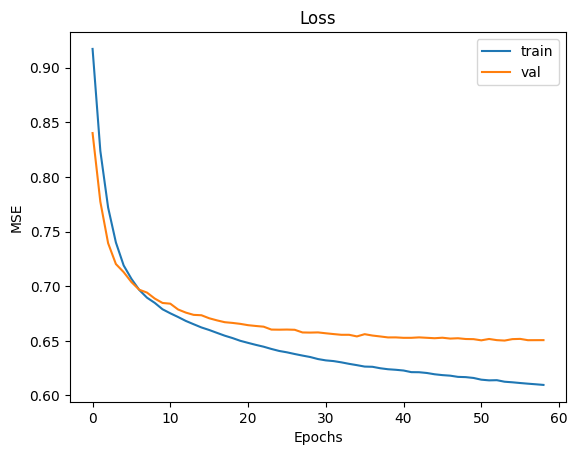

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(history["train_loss"], label='train')
plt.plot(history["val_mse"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE');
plt.legend()

In [ ]:
reg_predictions = utils.test(reg_model, r_test_iter)
reg_predictions = y_scaler.inverse_transform(reg_predictions)


print("Accuracy: ",  accuracy_from_floats(y_true=y_test, y_pred=reg_predictions),
      ", MSE: ",mse(y_true=y_test, y_pred=reg_predictions),
      ", MAE", mae(y_true=y_test, y_pred=reg_predictions))

Accuracy:  0.5510204081632653 , MSE:  0.5029345852758415 , MAE 0.5516026288710867


**Task 5.** Add an additional (*second*) hidden layer with the ReLU activation and input/output 30 neurons. Is the result better?

In [ ]:
class RegModel3(nn.Module):
  def __init__(self):
    super(RegModel3, self).__init__()
    self.layer = nn.Sequential(nn.Linear(in_features=11, out_features=30),
                                nn.ReLU(),
                                nn.Linear(in_features=30, out_features=30),
                                nn.ReLU(),
                                nn.Linear(in_features=30, out_features=1))



  def forward(self, x):
    return self.layer(x)



reg_model = RegModel3()
reg_model = reg_model.cuda()

history = utils.train(model=reg_model,
              loss=nn.MSELoss(),
              val_metrics={"mse": nn.MSELoss()},
              optimizer=torch.optim.SGD(reg_model.parameters(), lr=0.01),
              train_ds=r_train_iter,
              dev_ds=r_dev_iter,
              num_epochs=200,
              early_stopper=utils.EarlyStopper(metric_name="mse", patience=5))



epoch 1 train loss: 0.9885 val_mse: 0.9421
tensor(0.9421) None
epoch 2 train loss: 0.9147 val_mse: 0.8761
tensor(0.8761) tensor(0.9421)
epoch 3 train loss: 0.8587 val_mse: 0.8224
tensor(0.8224) tensor(0.8761)
epoch 4 train loss: 0.8116 val_mse: 0.7834
tensor(0.7834) tensor(0.8224)
epoch 5 train loss: 0.7740 val_mse: 0.7536
tensor(0.7536) tensor(0.7834)
epoch 6 train loss: 0.7441 val_mse: 0.7327
tensor(0.7327) tensor(0.7536)
epoch 7 train loss: 0.7222 val_mse: 0.7189
tensor(0.7189) tensor(0.7327)
epoch 8 train loss: 0.7056 val_mse: 0.7089
tensor(0.7089) tensor(0.7189)
epoch 9 train loss: 0.6942 val_mse: 0.7013
tensor(0.7013) tensor(0.7089)
epoch 10 train loss: 0.6855 val_mse: 0.6968
tensor(0.6968) tensor(0.7013)
epoch 11 train loss: 0.6793 val_mse: 0.6911
tensor(0.6911) tensor(0.6968)
epoch 12 train loss: 0.6732 val_mse: 0.6882
tensor(0.6882) tensor(0.6911)
epoch 13 train loss: 0.6690 val_mse: 0.6848
tensor(0.6848) tensor(0.6882)
epoch 14 train loss: 0.6645 val_mse: 0.6819
tensor(0.6819

/content/utils.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [ ]:
reg_predictions = utils.test(reg_model, r_test_iter)
reg_predictions = y_scaler.inverse_transform(reg_predictions)


print("Accuracy: ",  accuracy_from_floats(y_true=y_test, y_pred=reg_predictions),
      ", MSE: ",mse(y_true=y_test, y_pred=reg_predictions),
      ", MAE", mae(y_true=y_test, y_pred=reg_predictions))

Accuracy:  0.5459183673469388 , MSE:  0.49701865722541705 , MAE 0.5479685860307663


# Classification

**Task 6.** Let's approach this dataset with a logistic regression now. This time, you will have to predict the rating levels as **classes** (10), instead of treating the output as a scalar. Make sure that your results are **reproducible** by correctly 'seeding'. Use the SGD-optimizer with a learning rate of "0.01" and train for 200 epochs with early stopping with patience of 5 (and restore the best weights). Early stopping should interrupt the training if the loss on the validation data  does not improve for 5 epochs. Use accuracy to evaluate the intermediary results, during training.

In [ ]:
def np2iter_class(x, y, shuffle=True):
  x = torch.tensor(x, dtype=torch.float)
  y = torch.tensor(y, dtype=torch.long)

  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=64, shuffle=shuffle)

c_train_iter = np2iter_class(x_train, y_train, shuffle=True)
c_dev_iter =  np2iter_class(x_dev, y_dev, shuffle=False)
c_test_iter =  np2iter_class(x_test, y_test, shuffle=False)


In [ ]:
class ClassModel1(nn.Module):
  def __init__(self):
    super(ClassModel1, self).__init__()
    self.layer = nn.Linear(in_features=11, out_features=10)


  def forward(self, x):
    return self.layer(x)



def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred=y_pred, y_true=y_test)

classification_model = ClassModel1()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.01),
                            train_ds=c_train_iter,
                            dev_ds=c_dev_iter,
                            num_epochs=200,
                            early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 2.3960 val_cls: 2.3075 val_acc: 0.1449
tensor(2.3075) None
epoch 2 train loss: 2.2345 val_cls: 2.1585 val_acc: 0.2204
tensor(2.1585) tensor(2.3075)
epoch 3 train loss: 2.0971 val_cls: 2.0324 val_acc: 0.2857
tensor(2.0324) tensor(2.1585)
epoch 4 train loss: 1.9805 val_cls: 1.9259 val_acc: 0.3531
tensor(1.9259) tensor(2.0324)
epoch 5 train loss: 1.8817 val_cls: 1.8359 val_acc: 0.4061
tensor(1.8359) tensor(1.9259)
epoch 6 train loss: 1.7978 val_cls: 1.7593 val_acc: 0.4378
tensor(1.7593) tensor(1.8359)
epoch 7 train loss: 1.7260 val_cls: 1.6940 val_acc: 0.4633
tensor(1.6940) tensor(1.7593)
epoch 8 train loss: 1.6645 val_cls: 1.6380 val_acc: 0.4827
tensor(1.6380) tensor(1.6940)
epoch 9 train loss: 1.6117 val_cls: 1.5900 val_acc: 0.5010
tensor(1.5900) tensor(1.6380)
epoch 10 train loss: 1.5662 val_cls: 1.5485 val_acc: 0.5143
tensor(1.5485) tensor(1.5900)
epoch 11 train loss: 1.5269 val_cls: 1.5126 val_acc: 0.5102
tensor(1.5126) tensor(1.5485)
epoch 12 train loss: 1.4928 v

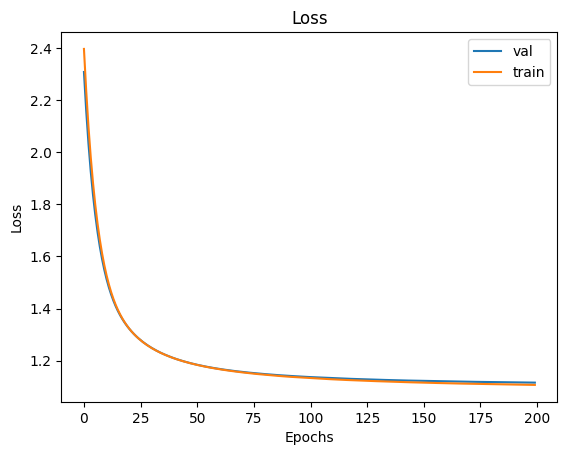

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, classification_report


class_predictions = utils.test(classification_model, c_test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=y_test, y_pred=class_predictions))


Accuracy:  0.5479591836734694 , MSE:  0.673469387755102 , MAE 0.5224489795918368


**Task 7.** Add an additional dense layer with the Relu activation and inputoutput 30 neurons. Is the result better?

In [ ]:
class ClassModel2(nn.Module):
  def __init__(self):
    super(ClassModel2, self).__init__()
    self.layer =nn.Sequential(nn.Linear(in_features=11, out_features=30),
                                nn.ReLU(),
                                nn.Linear(in_features=30, out_features=10))



  def forward(self, x):
    return self.layer(x)

classification_model = ClassModel2()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.01),
                            train_ds=c_train_iter,
                            dev_ds=c_dev_iter,
                            num_epochs=200,
                            early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 2.1629 val_cls: 2.0415 val_acc: 0.4041
tensor(2.0415) None
epoch 2 train loss: 1.9493 val_cls: 1.8561 val_acc: 0.4480
tensor(1.8561) tensor(2.0415)
epoch 3 train loss: 1.7854 val_cls: 1.7151 val_acc: 0.4459
tensor(1.7151) tensor(1.8561)
epoch 4 train loss: 1.6600 val_cls: 1.6082 val_acc: 0.4541
tensor(1.6082) tensor(1.7151)
epoch 5 train loss: 1.5639 val_cls: 1.5266 val_acc: 0.4684
tensor(1.5266) tensor(1.6082)
epoch 6 train loss: 1.4896 val_cls: 1.4631 val_acc: 0.4888
tensor(1.4631) tensor(1.5266)
epoch 7 train loss: 1.4312 val_cls: 1.4130 val_acc: 0.4908
tensor(1.4130) tensor(1.4631)
epoch 8 train loss: 1.3849 val_cls: 1.3731 val_acc: 0.5020
tensor(1.3731) tensor(1.4130)
epoch 9 train loss: 1.3478 val_cls: 1.3412 val_acc: 0.5010
tensor(1.3412) tensor(1.3731)
epoch 10 train loss: 1.3181 val_cls: 1.3155 val_acc: 0.4990
tensor(1.3155) tensor(1.3412)
epoch 11 train loss: 1.2939 val_cls: 1.2947 val_acc: 0.4990
tensor(1.2947) tensor(1.3155)
epoch 12 train loss: 1.2742 v

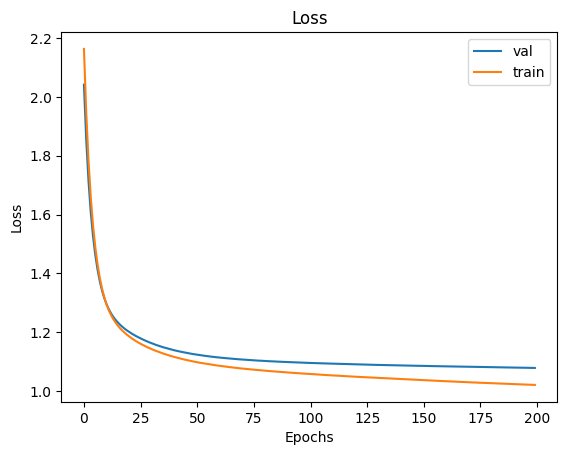

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

class_predictions = utils.test(classification_model, c_test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=y_test, y_pred=class_predictions))

Accuracy:  0.5510204081632653 , MSE:  0.6183673469387755 , MAE 0.5040816326530613


**Task 8.** Add an additional dense layer (a second hidden layer) with the ReLU activation and input/output 30 neurons. Is the result better?

In [ ]:
class ClassModel3(nn.Module):
  def __init__(self):
    super(ClassModel3, self).__init__()
    self.layer =nn.Sequential(nn.Linear(in_features=11, out_features=30),
                                nn.ReLU(),
                                nn.Linear(in_features=30, out_features=30),
                                nn.ReLU(),
                                nn.Linear(in_features=30, out_features=10))



  def forward(self, x):
    return self.layer(x)

classification_model = ClassModel3()
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.01),
                            train_ds=c_train_iter,
                            dev_ds=c_dev_iter,
                            num_epochs=200,
                            early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 2.1905 val_cls: 2.0965 val_acc: 0.4490
tensor(2.0965) None
epoch 2 train loss: 2.0149 val_cls: 1.9257 val_acc: 0.4490
tensor(1.9257) tensor(2.0965)
epoch 3 train loss: 1.8491 val_cls: 1.7662 val_acc: 0.4490
tensor(1.7662) tensor(1.9257)
epoch 4 train loss: 1.7001 val_cls: 1.6321 val_acc: 0.4490
tensor(1.6321) tensor(1.7662)
epoch 5 train loss: 1.5820 val_cls: 1.5337 val_acc: 0.4490
tensor(1.5337) tensor(1.6321)
epoch 6 train loss: 1.4976 val_cls: 1.4653 val_acc: 0.4490
tensor(1.4653) tensor(1.5337)
epoch 7 train loss: 1.4383 val_cls: 1.4175 val_acc: 0.4490
tensor(1.4175) tensor(1.4653)
epoch 8 train loss: 1.3964 val_cls: 1.3835 val_acc: 0.4490
tensor(1.3835) tensor(1.4175)
epoch 9 train loss: 1.3662 val_cls: 1.3588 val_acc: 0.4510
tensor(1.3588) tensor(1.3835)
epoch 10 train loss: 1.3435 val_cls: 1.3400 val_acc: 0.4582
tensor(1.3400) tensor(1.3588)
epoch 11 train loss: 1.3258 val_cls: 1.3251 val_acc: 0.4663
tensor(1.3251) tensor(1.3400)
epoch 12 train loss: 1.3113 v

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

class_predictions = utils.test(classification_model, c_test_iter)
class_predictions = np.argmax(class_predictions, axis=1)

print("Accuracy: ",  accuracy_score(y_true=y_test, y_pred=class_predictions),
      ", MSE: ",mse(y_true=y_test, y_pred=class_predictions),
      ", MAE", mae(y_true=y_test, y_pred=class_predictions))

**Task 9** Write a short report about your findings and answer the following questions:


1. Is the wine problem a classification task (or a regression task)? Can be both, but the classification setting considers the importance of the mistaken classes to be the same. If we predict rating 1 instead of 10,it is equivalent to predicting rating 9. The regression setting would consider rating 9 to be much better.

2. What is the most suitable metric for our task (MSE, MAE, accuracy)? Not accuracy ()
3. Which model is the best performer overall?
4. Is 'deeper' always better? No, we might get overfitting.
5. Add other your findings you want to share.

